## 🛠️ Mod5 Data Challenge 3: Data Transformations


**Goal:** Practice using data transformations and interpreting the transformation to stakeholders

**Structure**
- Instructor: perform a square root and box-cox transformation on response time
- Students: build a new feature and chose ONE transformation 
- Wrap-up: talk through chosen transformation and its interpretability 


### Data
Use the **nyc311.csv** file located in your Github's `data` folder within Mod5/DataChallenges.  This is a sample of the originial file looking at just one week of data since the dataset is HUGE.  Read more about the columns [HERE](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data).   

### 👩‍🏫 Instructor-Led Demo (25 minutes)


#### Step 0:  Read in & Prep the Data 
* You have seen a majority of this code already!  
* Read in data, and run the next cell AS IS! 

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("/Users/Marcy_Student/Desktop/notebooks/nyc311.csv")

In [63]:
# RUN THIS CELL WITHOUT CHANGES 

# Helper: robust tz conversion
LOCAL_TZ = "America/New_York"

def to_utc(series, local_tz=LOCAL_TZ):
    s = pd.to_datetime(series, errors="coerce")
    if s.dt.tz is None:
        s = s.dt.tz_localize(local_tz, nonexistent="shift_forward", ambiguous="NaT")
    return s.dt.tz_convert("UTC")

# Identify likely datetime columns
candidate_created = [c for c in df.columns if "Created" in c and "Date" in c]
candidate_closed  = [c for c in df.columns if "Closed"  in c and "Date" in c]
if not candidate_created or not candidate_closed:
    raise KeyError("Could not find 'Created Date' and 'Closed Date' columns. Rename or update detection logic.")

CREATED_COL, CLOSED_COL = candidate_created[0], candidate_closed[0]

# Drop nulls, convert to tz-aware UTC
df = df.dropna(subset=[CREATED_COL, CLOSED_COL]).copy()
df[CREATED_COL] = to_utc(df[CREATED_COL])
df[CLOSED_COL]  = to_utc(df[CLOSED_COL])
df = df.dropna(subset=[CREATED_COL, CLOSED_COL])

# Compute response time (hrs)
delta = df[CLOSED_COL] - df[CREATED_COL]
df["response_time_hrs"] = delta.dt.total_seconds() / 3600

# Base temporal features
df["hour_of_day"] = df[CREATED_COL].dt.hour
df["weekday"]     = df[CREATED_COL].dt.weekday  # 0=Mon
df["is_weekend"]  = df["weekday"] >= 5
df["is_night"]    = df["hour_of_day"].isin([0,1,2,3,4,5])
df["is_peak_commute"] = df["hour_of_day"].isin([7,8,9,16,17,18,19])

# Complaint text normalization (helps reproducibility)
if "Complaint Type" in df.columns:
    df["complaint_norm"] = (df["Complaint Type"].astype(str)
                            .str.normalize("NFKC")
                            .str.strip()
                            .str.casefold())
else:
    df["complaint_norm"] = ""

# High-priority complaint flag (example list)
priority_list = {"heat/hot water","electric","elevator","structural","gas","sewer","water system"}
df["is_high_priority"] = df["complaint_norm"].isin(priority_list)

# Borough normalization + a borough flag (example)
if "Borough" in df.columns:
    df["borough_norm"] = df["Borough"].astype(str).str.strip().str.title()
    example_borough = "Brooklyn"
    df["is_brooklyn"] = df["borough_norm"].eq(example_borough)
else:
    df["borough_norm"] = ""
    df["is_brooklyn"] = False

# Clean negatives & NaNs for response_time_hrs
df = df[df["response_time_hrs"] >= 0].dropna(subset=["response_time_hrs"]).copy()

df.head(3)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,response_time_hrs,hour_of_day,weekday,is_weekend,is_night,is_peak_commute,complaint_norm,is_high_priority,borough_norm,is_brooklyn
7,66176906,2025-09-17 05:49:53+00:00,2025-09-17 07:00:34+00:00,DHS,Department of Homeless Services,Homeless Person Assistance,Non-Chronic,Store/Commercial,11385.0,55-25 MYRTLE AVENUE,...,1.178056,5,2,False,True,False,homeless person assistance,False,Queens,False
37,66170659,2025-09-17 05:33:27+00:00,2025-09-17 05:42:59+00:00,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11419.0,111-01 101 AVENUE,...,0.158889,5,2,False,True,False,blocked driveway,False,Queens,False
43,66175356,2025-09-17 05:29:57+00:00,2025-09-17 05:46:21+00:00,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10009.0,103 AVENUE B,...,0.273333,5,2,False,True,False,noise - residential,False,Manhattan,False


#### Step 1:  Clip the Variable (can't take log of 0)


In [64]:
df["response_time_hrs"] = df['response_time_hrs'].clip(lower = .01)

### Side Teaching Note:  Comparison of Transformations

| Transformation | Formula              | Use Case                    | Interpretation Challenge     |
|----------------|----------------------|-----------------------------|------------------------------|
| Log            | log(x + 1)           | Right-skewed with large outliers | Hard to explain to non-techs |
| Square Root    | sqrt(x)              | Moderate skew, less extreme | Easier to interpret          |
| Box-Cox        | scipy boxcox(x)      | Strictly positive data, allows tuning | Hardest to interpret |

> 📝 Reminder: Box-Cox finds the best power transformation to make your data more normal.


#### 🧠 So How Do I Interpret Box-Cox Transformed Values?

Box-Cox transformations help smooth out skewed data by automatically applying a power function (like square root, log, cube root, etc.). The transformed values are **no longer in the original units** (like hours), so we need to interpret them carefully.

---

#### 🤔 Say You Have:
- A Box-Cox transformed value = **3**
- The transformation used **λ = 0.25**

To get the original value (e.g., in hours), use this formula:

x = ((λ * BoxCox_Value) + 1)^(1/λ)

In this example:

x = ((0.25 * 3) + 1)^(1 / 0.25)
= (1.75)^4
≈ 9.4


✅ So a value of **3** on your transformed x-axis corresponds to about **9.4 hours** in the original data.

---

### Box-Cox Table

| Box-Cox Value | What It Suggests             | Notes                                 |
|---------------|-------------------------------|----------------------------------------|
| 0–1           | Very fast response time        | Maybe a quick fix (<3 hrs)             |
| 2–3           | Typical requests               | Likely around 5–10 hours               |
| 4+            | Long or delayed responses      | Possibly 1+ day (24+ hours)            |

> 📌 Reminder: The **exact mapping** depends on the λ used.  
> Box-Cox helps make skewed data more bell-shaped for analysis —  
> but always remember it's a transformed scale!


#### Step 2:  Apply the 3 transformations listed in the first table above

In [65]:
df["sqrt_response_time"] = np.sqrt(df['response_time_hrs'])
df["log_response_time"] =  np.log(df['response_time_hrs'])
df["boxcox_response_time"], fitted_lambda = stats.boxcox(df['response_time_hrs'])

print(f"Box-Cox lambda: {fitted_lambda:.3f}")

Box-Cox lambda: 0.020


#### Step 3:  Visualize the tramsformations

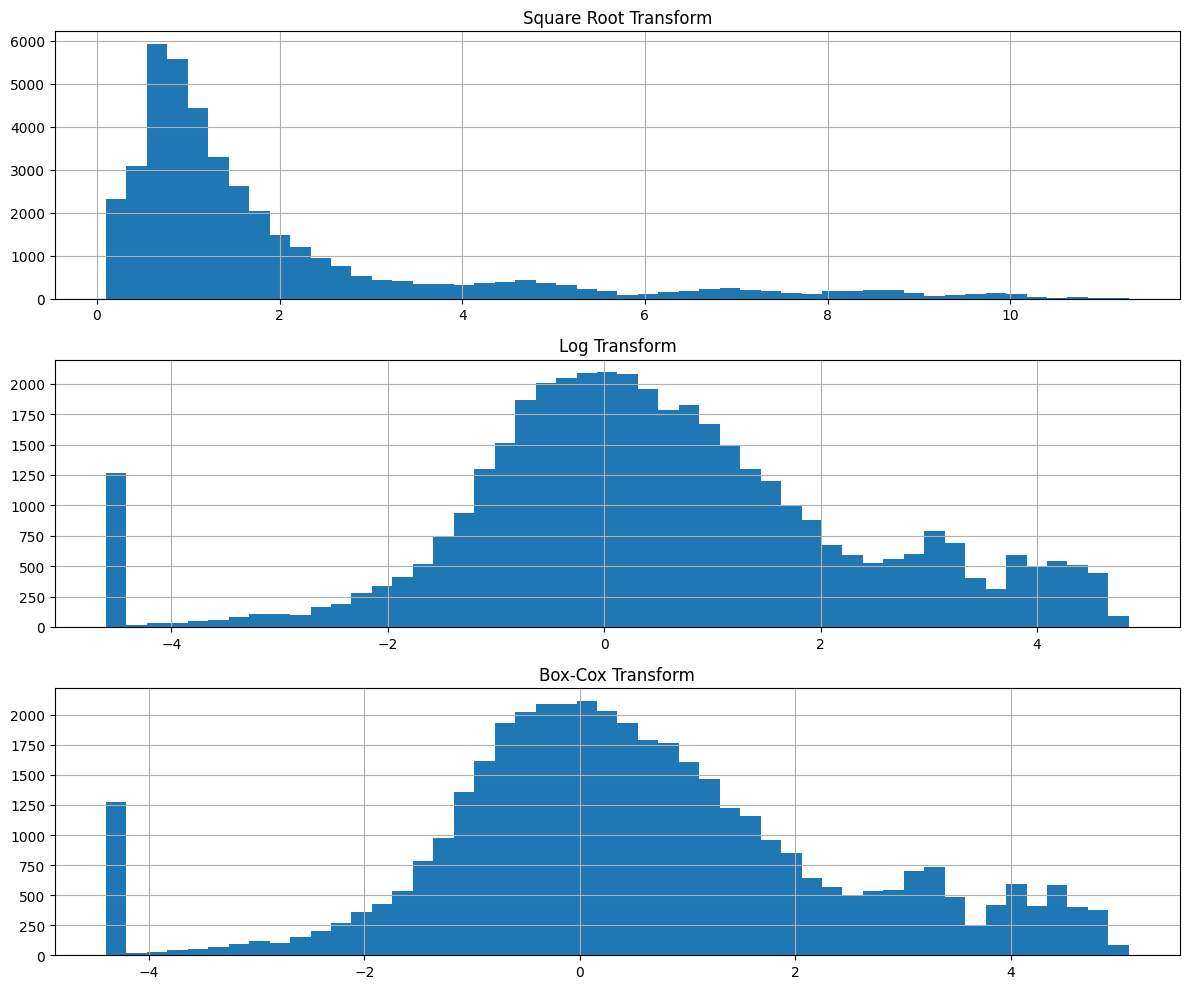

In [66]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
df["sqrt_response_time"].hist(bins=50)
plt.title("Square Root Transform")

plt.subplot(3, 1, 2)
df['log_response_time'].hist(bins = 50)
plt.title("Log Transform")

plt.subplot(3, 1, 3)
df['boxcox_response_time'].hist(bins = 50)
plt.title("Box-Cox Transform")

plt.tight_layout()
plt.show()


#### Instructor Section Notes: Interpreting the Histogram

- In the **log-transformed** version, the peak of the histogram is near `log ≈ 2`.
    - This means most complaints were resolved in about \( e^2 ≈ 7.4 \) hours.
- In the **square root** version, the peak is closer to `sqrt ≈ 3`, which corresponds to \( 3^2 = 9 \) hours.
    - **Interpretation:** Transformations reduce the influence of extreme outliers and let us better see the "typical" experience.


- Stakeholders now get a more realistic view of service performance (e.g., “most are resolved in 7–9 hours”), instead of being distracted by rare 48-hour delays.


### 👩‍💻 Student-Led Section (15 minutes)

To avoid duplicating the instructor’s work, you will:

1) Create **hourly intake** = number of new 311 requests **created per hour** (focus on one borough to keep it coherent).
2) Choose **one** transformation: "sqrt", "log", or "boxcox".
3) Plot a histogram of the transformed hourly intake.
4) Interpret the histogram (translate one meaningful value back to the original scale).



#### Task 1:  Build Hourly Intake 


In [67]:
# 1) Pick a borough to analyze (match your dataset's capitalization after normalization if used)
target_borough = 'Queens'  # e.g., "Brooklyn"

# 2) Identify your Created Date column (auto-detected earlier as CREATED_COL). We reuse it here.
#    If you don't have CREATED_COL in memory, set it explicitly to your column name.
created_col = CREATED_COL if 'CREATED_COL' in globals() else "Created Date"

# 3) Filter to that borough (assumes you have a normalized borough column like 'borough_norm')
df_b = df[df["borough_norm"] == target_borough].copy()

# 4) Truncate to hour and count requests per hour
df_b["created_hour"] = df_b[created_col].dt.floor("H")
hourly = (df_b
          .groupby(df_b['created_hour'], as_index=False)
          .size()
          .rename(columns={"size":"hourly_intake"}))

hourly.head()


/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_81311/2154602197.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_b["created_hour"] = df_b[created_col].dt.floor("H")


,created_hour,hourly_intake
0,2025-09-11 14:00:00+00:00,25
1,2025-09-11 15:00:00+00:00,134
2,2025-09-11 16:00:00+00:00,112
3,2025-09-11 17:00:00+00:00,106
4,2025-09-11 18:00:00+00:00,95


#### Task 2: Choose ONE Transformation AND Apply It

In [68]:
# make a working copy
h = hourly.copy()
h["hourly_intake"] = h["hourly_intake"].clip(lower=0.01)

chosen_method = 'log'   # "sqrt" or "log" or "boxcox"

if chosen_method == "sqrt":
    h["intake_transformed"] = None
elif chosen_method == "log":
    h["intake_transformed"] = np.log(h['hourly_intake']) 
elif chosen_method == "boxcox":
    # Box-Cox requires strictly positive values
    h["intake_transformed"], lambda_bc = None  
    print("Box-Cox λ:", lambda_bc)
else:
    raise ValueError("Please choose 'sqrt', 'log', or 'boxcox' for chosen_method.")



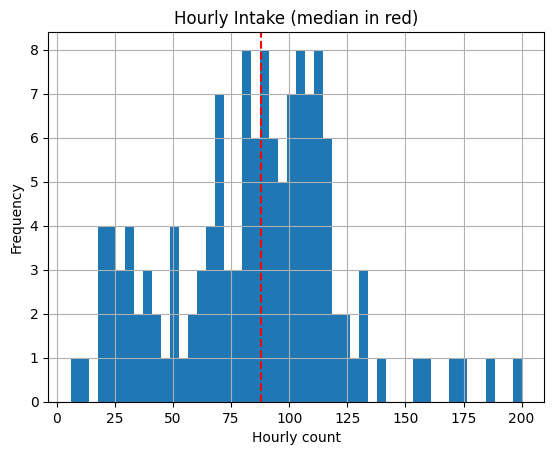

In [71]:
h['hourly_intake'].hist(bins = 50)
plt.axvline(h["hourly_intake"].median(), color="red", linestyle="--")
plt.title(f"Hourly Intake (median in red)")
plt.xlabel("Hourly count")
plt.ylabel("Frequency")
plt.show()

#### Task 3 — Plot a Histogram

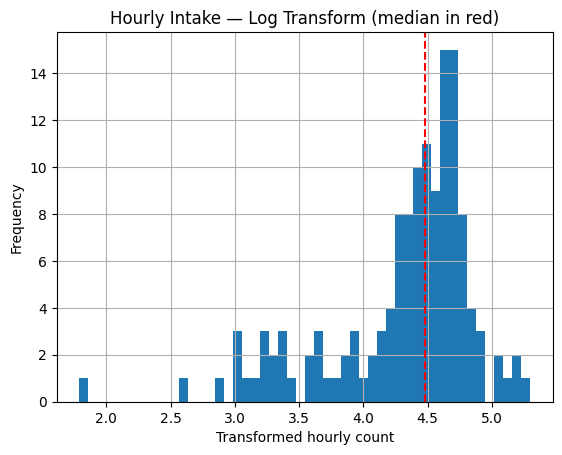

In [70]:
h["intake_transformed"].hist(bins = 50)
plt.axvline(h["intake_transformed"].median(), color="red", linestyle="--")
plt.title(f"Hourly Intake — {chosen_method.capitalize()} Transform (median in red)")
plt.xlabel("Transformed hourly count")
plt.ylabel("Frequency")
plt.show()


### Interpretation of Your Transformed Histogram (Fill in answers to the questions)

- What did the **raw** hourly intake distribution look like (right-skewed? clumpy?) before transforming?
- After transforming, is the shape **more symmetric** or easier to summarize?
- Interpret a **concrete value**: pick the median (red line) from the transformed plot and convert back.
  - For **log**: if median ≈ 1.6 ⇒ hourly intake ≈ \( e^{1.6} \approx 5 \) requests/hour.
  - For **sqrt**: if median ≈ 3 ⇒ hourly intake ≈ \( 3^2 = 9 \) requests/hour.
  - For **Box-Cox**: use the inverse of the Box-Cox with the printed λ (view instructor notes at the beginning).
- Would this transformation help for **dashboards** (clearer “typical” load), **capacity planning** (crews per hour), or **modeling** (e.g., forecasting intake)?


1.The raw hourly intake distribution looked relatively normal with a slight right-skew
2. A bit left-skewed and clumpy.
3. e ^(4.45) ≈ 86 request / hour
4. This transformation would help with capacity planning. 86 request per hour is approximately a request every 42 seconds. If request are that frequent, then we need to know that we have the work force to handle it

### 📣 Class Share-Out & Instructor Wrap-Up (20 minutes)

Be ready to share out the following points with the class: 

**Explain:**
Your chosen transformation and how would this transformation help a hypothetical stakeholder

#### Instructor Wrap-Up (Notes)


- Different feature → different story: transforming **hourly intake** answers “how many incoming requests per hour,” not “how long resolution takes.”
- **Interpretability vs. power:**
  - `sqrt` is intuitive (“bigger grows slower”), good for dashboards.
  - `log` strongly reduces skew; be ready to translate back for stakeholders.
  - `boxcox` can improve model fit but is hardest to explain; document λ and why you used it.
- Always convert one **concrete value** back to original units (e.g., “median ≈ 5 requests/hour”).
- Visual checks matter: show **before/after** shape when you present final results (even if students only plotted one).
- Next step: try the same transformation across **different boroughs or complaint types** to see if patterns generalize.

